In [14]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pylidc as pl

In [2]:
scans = pl.query(pl.Scan).all()
print("Total scans:", len(scans))


Total scans: 1018


In [2]:
import pylidc as pl

scans = pl.query(pl.Scan).all()
print("Total scans in pylidc DB:", len(scans))


Total scans in pylidc DB: 1018


In [3]:
import os

DATA_PATH = "/home/harsh/Harsh_25MAI0040/LIDC_new/data/LIDC-IDRI"

print("Folders found:", len(os.listdir(DATA_PATH)))
print(os.listdir(DATA_PATH)[:5])


Folders found: 3075
['1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286', '1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440', '1.3.6.1.4.1.14519.5.2.1.6279.6001.149484561117305919058718221926', '1.3.6.1.4.1.14519.5.2.1.6279.6001.205174485766424333452131788504', '1.3.6.1.4.1.14519.5.2.1.6279.6001.663019255629770796363333877035']


Testing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824
Original shape: (87, 512, 512)
Original spacing: (3.0, 0.65, 0.65)
Resampled shape: (261, 333, 333)
Nodules found: 4
Cube shape: (64, 64, 64)


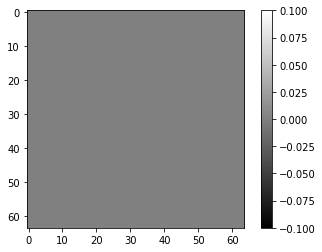

In [15]:
from preprocessing.dicom_loader import load_dicom_series
from preprocessing.resample import resample_volume
from preprocessing.lung_segmentation import segment_lungs
from preprocessing.hu_normalization import normalize_hu
from preprocessing.roi_extraction import extract_cube

import numpy as np

scan = scans[0]
series_uid = scan.series_instance_uid
series_folder = os.path.join(DATA_PATH, series_uid)

print("Testing scan:", series_uid)

volume, spacing = load_dicom_series(series_folder)
print("Original shape:", volume.shape)
print("Original spacing:", spacing)

volume, _ = resample_volume(volume, spacing, (1.0,1.0,1.0))
print("Resampled shape:", volume.shape)

volume = segment_lungs(volume)
volume = normalize_hu(volume)

nodules = scan.cluster_annotations()
print("Nodules found:", len(nodules))

if len(nodules) > 0:
    centroid = np.array(nodules[0][0].centroid)
    
    scale_factor = np.array(spacing) / np.array((1.0,1.0,1.0))
    centroid = centroid * scale_factor
    
    cube = extract_cube(volume, centroid, 64)

    print("Cube shape:", cube.shape)
    
mid = cube.shape[0] // 2
plt.imshow(cube[mid], cmap="gray")
plt.colorbar()
plt.show()


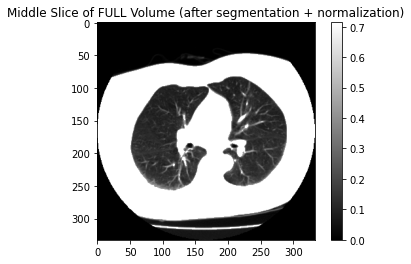

In [9]:
import matplotlib.pyplot as plt

mid_z = volume.shape[0] // 2
plt.imshow(volume[mid_z], cmap="gray")
plt.title("Middle Slice of FULL Volume (after segmentation + normalization)")
plt.colorbar()
plt.show()


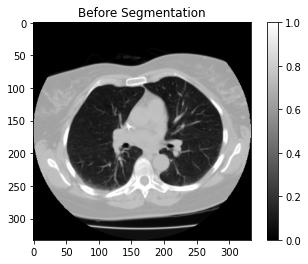

In [10]:
volume_raw, spacing = load_dicom_series(series_folder)

volume_resampled, _ = resample_volume(volume_raw, spacing, (1.0,1.0,1.0))
volume_norm = normalize_hu(volume_resampled)

mid_z = volume_norm.shape[0] // 2
plt.imshow(volume_norm[mid_z], cmap="gray")
plt.title("Before Segmentation")
plt.colorbar()
plt.show()


Testing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824
Original shape: (87, 512, 512)
Original spacing: (3.0, 0.65, 0.65)
Nodules found: 4
Original centroid (voxel space): [ 25.64987406 312.30982368 331.90680101]
Cube shape (before resample): (64, 64, 64)
Cube shape after resample: (192, 42, 42)


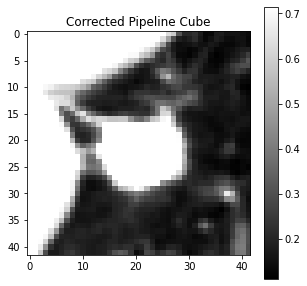

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pylidc as pl

from preprocessing.dicom_loader import load_dicom_series
from preprocessing.resample import resample_volume
from preprocessing.lung_segmentation import segment_lungs
from preprocessing.hu_normalization import normalize_hu
from preprocessing.roi_extraction import extract_cube


DATA_PATH = "data/LIDC-IDRI"
TARGET_SPACING = (1.0, 1.0, 1.0)
CUBE_SIZE = 64

scans = pl.query(pl.Scan).all()
scan = scans[0]

series_uid = scan.series_instance_uid
series_folder = os.path.join(DATA_PATH, series_uid)

print("Testing scan:", series_uid)

# 1️⃣ Load original volume
volume_raw, spacing = load_dicom_series(series_folder)
print("Original shape:", volume_raw.shape)
print("Original spacing:", spacing)

# 2️⃣ Segment in original space (HU space)
volume_segmented = segment_lungs(volume_raw)

# 3️⃣ Get nodules
nodules = scan.cluster_annotations()
print("Nodules found:", len(nodules))

if len(nodules) > 0:

    c = np.array(nodules[0][0].centroid)

    # Convert pylidc (row, col, slice) → (slice, row, col)
    centroid = np.array([c[2], c[0], c[1]])

    print("Original centroid (voxel space):", centroid)

    # 4️⃣ Extract cube in ORIGINAL voxel space
    cube = extract_cube(volume_segmented, centroid, CUBE_SIZE)
    print("Cube shape (before resample):", cube.shape)

    # 5️⃣ Resample cube to 1mm³
    cube_resampled, _ = resample_volume(cube, spacing, TARGET_SPACING)

    # 6️⃣ Normalize
    cube_final = normalize_hu(cube_resampled)

    print("Cube shape after resample:", cube_final.shape)

    mid = cube_final.shape[0] // 2

    plt.figure(figsize=(5,5))
    plt.imshow(cube_final[mid], cmap="gray")
    plt.title("Corrected Pipeline Cube")
    plt.colorbar()
    plt.show()


In [16]:
from preprocessing.dataset_builder import build_dataset
build_dataset()

Total scans in pylidc DB: 1018


  6%|██▍                                    | 65/1018 [07:01<1:47:07,  6.74s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 10%|███▊                                   | 99/1018 [10:35<1:29:27,  5.84s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 14%|█████▏                                | 139/1018 [14:55<1:35:16,  6.50s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 20%|███████▌                              | 204/1018 [21:46<1:23:19,  6.14s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 25%|█████████▎                            | 251/1018 [26:51<1:28:43,  6.94s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 33%|█████████████                           | 333/1018 [34:57<53:34,  4.69s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 33%|████████████▋                         | 341/1018 [35:46<1:04:04,  5.68s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 36%|██████████████▍                         | 369/1018 [38:21<52:20,  4.84s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 40%|███████████████▏                      | 407/1018 [42:04<1:01:18,  6.02s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 60%|██████████████████████▊               | 612/1018 [1:01:56<35:26,  5.24s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 70%|██████████████████████████▌           | 712/1018 [1:11:35<29:09,  5.72s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 78%|█████████████████████████████▍        | 789/1018 [1:18:41<25:27,  6.67s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 78%|█████████████████████████████▌        | 791/1018 [1:18:54<25:10,  6.65s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 82%|███████████████████████████████▎      | 839/1018 [1:23:27<16:43,  5.61s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


100%|█████████████████████████████████████| 1018/1018 [1:40:30<00:00,  5.92s/it]



Stage-1 completed.
Detection samples: 5705
Malignancy samples: 5705


In [17]:
import torch

data = torch.load("processed_data/joint_dataset.pt")

print("Total samples:", len(data))
print("Sample structure:", type(data[0]))
print("Tensor shape:", data[0][0].shape)
print("Detection label:", data[0][1])
print("Malignancy label:", data[0][2])
print("Series UID:", data[0][3])


Total samples: 5705
Sample structure: <class 'tuple'>
Tensor shape: torch.Size([1, 64, 64, 64])
Detection label: 1
Malignancy label: 3.75
Series UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824


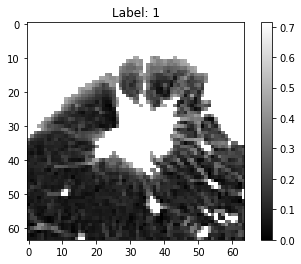

In [21]:
import random
import matplotlib.pyplot as plt

sample = random.choice(data)

cube = sample[0].squeeze().numpy()
label = sample[1]

mid = cube.shape[0] // 2

plt.imshow(cube[mid], cmap="gray")
plt.title(f"Label: {label}")
plt.colorbar()
plt.show()


In [22]:
positives = sum([1 for x in data if x[1] == 1])
negatives = sum([1 for x in data if x[1] == 0])

print("Positives:", positives)
print("Negatives:", negatives)
print("Positive ratio:", positives / len(data))


Positives: 2651
Negatives: 3054
Positive ratio: 0.4646801051709027


In [23]:
from datasets.split_manager import create_patient_split
create_patient_split()


Total unique patients: 1018
Train samples: 4558
Validation samples: 1147

Patient-level split completed successfully.


In [24]:
import torch

train = torch.load("processed_data/train_joint.pt")
val = torch.load("processed_data/val_joint.pt")

train_patients = set([x[3] for x in train])
val_patients = set([x[3] for x in val])

print("Overlap patients:", len(train_patients.intersection(val_patients)))


Overlap patients: 0


In [25]:
from datasets.joint_dataset import JointLungDataset

train_dataset = JointLungDataset(
    "processed_data/train_joint.pt",
    augment=True
)

print("Train size:", len(train_dataset))

cube, det, mal = train_dataset[0]

print("Cube shape:", cube.shape)
print("Detection label:", det)
print("Malignancy label:", mal)


Train size: 4558
Cube shape: torch.Size([1, 64, 64, 64])
Detection label: tensor(1)
Malignancy label: tensor(3.7500)


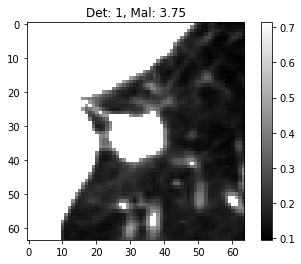

In [26]:
import matplotlib.pyplot as plt

mid = cube.shape[1] // 2

plt.imshow(cube[0, mid].numpy(), cmap="gray")
plt.title(f"Det: {det.item()}, Mal: {mal.item():.2f}")
plt.colorbar()
plt.show()


In [27]:
import torch
from models.backbone3d import Backbone3D

model = Backbone3D(feature_dim=256)

dummy = torch.randn(2, 1, 64, 64, 64)
out = model(dummy)

print("Output shape:", out.shape)


Output shape: torch.Size([2, 256])


In [28]:
from models.detector_head import DetectionHead

head = DetectionHead(feature_dim=256)

dummy_features = torch.randn(4, 256)
out = head(dummy_features)

print("Output shape:", out.shape)


Output shape: torch.Size([4, 1])


In [29]:
from models.backbone3d import Backbone3D
from models.detector_head import DetectionHead

backbone = Backbone3D(feature_dim=256)
head = DetectionHead(feature_dim=256)

dummy = torch.randn(2, 1, 64, 64, 64)

features = backbone(dummy)
logits = head(features)

print("Features shape:", features.shape)
print("Logits shape:", logits.shape)


Features shape: torch.Size([2, 256])
Logits shape: torch.Size([2, 1])


In [30]:
from models.malignancy_head import MalignancyHead

head = MalignancyHead(feature_dim=256)

dummy_features = torch.randn(4, 256)
out = head(dummy_features)

print("Output shape:", out.shape)


Output shape: torch.Size([4, 1])


In [31]:
from models.backbone3d import Backbone3D
from models.detector_head import DetectionHead
from models.malignancy_head import MalignancyHead

backbone = Backbone3D(feature_dim=256)
det_head = DetectionHead(feature_dim=256)
mal_head = MalignancyHead(feature_dim=256)

dummy = torch.randn(2, 1, 64, 64, 64)

features = backbone(dummy)

det_logits = det_head(features)
mal_score = mal_head(features)

print("Detection logits:", det_logits.shape)
print("Malignancy score:", mal_score.shape)


Detection logits: torch.Size([2, 1])
Malignancy score: torch.Size([2, 1])


In [32]:
import torch
from models.dual_head_model import DualHeadModel

model = DualHeadModel(feature_dim=256)

dummy = torch.randn(4, 1, 64, 64, 64)

det_logits, mal_score = model(dummy)

print("Detection logits:", det_logits.shape)
print("Malignancy score:", mal_score.shape)


Detection logits: torch.Size([4, 1])
Malignancy score: torch.Size([4, 1])


In [34]:
from training.losses import MultiTaskLoss

criterion = MultiTaskLoss()

det_logits = torch.randn(4, 1)
mal_pred = torch.randn(4, 1)

det_target = torch.tensor([1, 0, 1, 0])
mal_target = torch.tensor([4.0, 0.0, 3.5, 0.0])

total, det_loss, mal_loss = criterion(
    det_logits, mal_pred, det_target, mal_target
)

print("Total loss:", total.item())
print("Detection loss:", det_loss.item())
print("Malignancy loss:", mal_loss.item())


Total loss: 1.3214300870895386
Detection loss: 0.5650397539138794
Malignancy loss: 1.5127806663513184
